# Task 11 – Optimal Control of Storage

This notebook implements an optimization model for a Home Energy Management System (HEMS) with battery storage.


In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# Remove 'Agg' backend to allow inline display in notebooks
%matplotlib inline

from IPython.display import display

try:
    import cvxpy as cp
    USE_CVXPY = True
except ImportError:
    USE_CVXPY = False
    print("cvxpy not installed, optimization will be skipped")

try:
    import xgboost as xgb
    USE_XGBOOST = True
except ImportError:
    USE_XGBOOST = False
    print("xgboost not installed")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

ROOT = Path().resolve().parent
DATA_PATH = ROOT / "data" / "raw"
TABLE_PATH = ROOT / "reports" / "tables"
FIGURE_PATH = ROOT / "reports" / "figures"
TABLE_PATH.mkdir(parents=True, exist_ok=True)
FIGURE_PATH.mkdir(parents=True, exist_ok=True)

sys.path.insert(0, str(ROOT / "src"))
from modeling_ml import train_xgboost, predict_xgboost


def add_lag_features(df, target_col="Demand", lags=[1, 2, 3, 24, 48]):
    """Add lagged features for the target column."""
    data = df.copy()
    for lag in lags:
        data[f"{target_col.lower()}_lag_{lag}"] = data[target_col].shift(lag)
    return data


def add_time_features(df):
    """Add time-based features."""
    data = df.copy()
    data["hour"] = data["timestamp"].dt.hour
    data["hour_sin"] = np.sin(2 * np.pi * data["hour"] / 24)
    data["hour_cos"] = np.cos(2 * np.pi * data["hour"] / 24)
    data["dayofweek"] = data["timestamp"].dt.dayofweek
    data["is_weekend"] = (data["dayofweek"] >= 5).astype(int)
    return data


# Academic style configuration
def set_academic_style():
    """Configure matplotlib for publication-quality figures."""
    mpl.rcParams.update({
        # Figure
        "figure.figsize": (10, 4),
        "figure.dpi": 100,
        "figure.facecolor": "white",
        "savefig.facecolor": "white",
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        # Axes
        "axes.facecolor": "white",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "axes.axisbelow": True,
        "axes.titlesize": 12,
        "axes.titleweight": "bold",
        "axes.labelsize": 11,
        "axes.labelweight": "medium",
        # Grid
        "grid.color": "#E0E0E0",
        "grid.linestyle": "-",
        "grid.linewidth": 0.5,
        "grid.alpha": 0.7,
        # Font
        "font.size": 10,
        "font.family": "sans-serif",
        # Legend
        "legend.fontsize": 9,
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.edgecolor": "gray",
        # Ticks
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "xtick.direction": "out",
        "ytick.direction": "out",
    })


# Color palette for consistent styling
COLORS = {
    "demand": "#1f77b4",      # Blue
    "pv": "#ff7f0e",          # Orange
    "grid_import": "#d62728", # Red
    "grid_export": "#2ca02c", # Green
    "battery": "#9467bd",     # Purple
    "soc": "#17becf",         # Cyan
    "price": "#8c564b",       # Brown
}


def save_figure(fig, filename):
    """Save figure and display it."""
    fig.tight_layout()
    output_path = FIGURE_PATH / filename
    fig.savefig(output_path, dpi=300, bbox_inches="tight", facecolor="white", edgecolor="none")
    plt.show()
    print(f"✓ Figure saved: {filename}")


def display_table(df, filename):
    """Save table to CSV and display it."""
    output_path = TABLE_PATH / filename
    df.to_csv(output_path, index=False)
    display(df)


set_academic_style()
print("Setup complete. CVXPY available:", USE_CVXPY, "| XGBoost available:", USE_XGBOOST)

(CVXPY) Dec 11 07:15:47 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libmkl_rt.2.dylib\n  Referenced from: <D8729A1C-CFE9-3397-89EC-E45F5ADDD8F2> /Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so\n  Reason: tried: '/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/../../libmkl_rt.2.dylib' (no such file), '/Users/samuel/opt/anaconda3/envs/ML/lib/python3.10/site-packages/../../libmkl_rt.2.dylib' (no such file), '/Users/samuel/opt/anaconda3/envs/ML/bin/../lib/libmkl_rt.2.dylib' (no such file), '/Users/samuel/opt/anaconda3/envs/ML/bin/../lib/libmkl_rt.2.dylib' (no such file), '/usr/local/lib/libmkl_rt.2.dylib' (no such file), '/usr/lib/libmkl_rt.2.dylib' (no such file, not in dyld cache)")


Setup complete. CVXPY available: True | XGBoost available: True


In [ ]:

# STEP 1: Load training data and train XGBoost model for demand forecasting


train_file = DATA_PATH / "train_252145.csv"
df_train = pd.read_csv(train_file, parse_dates=["timestamp"])
df_train["timestamp"] = pd.to_datetime(df_train["timestamp"], utc=True)
print(f"Loaded training data: {len(df_train)} rows, {df_train['timestamp'].min()} to {df_train['timestamp'].max()}")

# Add features for demand forecasting
df_train = add_lag_features(df_train, target_col="Demand", lags=[1, 2, 3, 24, 48])
df_train = add_time_features(df_train)

# Define AR-only features (same as Task 9/10)
ar_features = ["demand_lag_1", "demand_lag_2", "demand_lag_3", "demand_lag_24", "demand_lag_48",
               "hour_sin", "hour_cos", "is_weekend"]

# Only drop rows with NaN in features we need
cols_needed = ar_features + ["Demand"]
df_train_clean = df_train.dropna(subset=cols_needed)

X_train = df_train_clean[ar_features].values.astype(np.float32)
y_train = df_train_clean["Demand"].values.astype(np.float32)

print(f"Training XGBoost model on {len(X_train)} samples with {len(ar_features)} features...")
xgb_model, _ = train_xgboost(X_train, y_train, params={
    "n_estimators": 600,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8
})
print("XGBoost model trained successfully")


Loaded training data: 8759 rows, 2013-07-01 00:00:00+00:00 to 2014-06-30 23:00:00+00:00
Training XGBoost model on 8711 samples with 8 features...
✓ XGBoost model trained successfully
✓ XGBoost model trained successfully


In [ ]:

# STEP 2: Load optimisation.csv and forecast demand for 24 hours


optim_file = DATA_PATH / "optimisation.csv"
df_optim = pd.read_csv(optim_file, parse_dates=["timestamp"])
df_optim["timestamp"] = pd.to_datetime(df_optim["timestamp"], utc=True)
print(f"Loaded optimisation.csv: {len(df_optim)} rows")
print(f"Time range: {df_optim['timestamp'].min()} to {df_optim['timestamp'].max()}")
print(f"Available columns: {df_optim.columns.tolist()}")

# Get the last 48 hours from training data for lag features
df_context = df_train.tail(48).copy()

# Combine context with optimisation period for feature engineering
df_combined = pd.concat([df_context[["timestamp", "Demand"]], 
                         df_optim[["timestamp"]].assign(Demand=np.nan)], ignore_index=True)
df_combined = df_combined.sort_values("timestamp").reset_index(drop=True)

# Add time features
df_combined["hour"] = df_combined["timestamp"].dt.hour
df_combined["hour_sin"] = np.sin(2 * np.pi * df_combined["hour"] / 24)
df_combined["hour_cos"] = np.cos(2 * np.pi * df_combined["hour"] / 24)
df_combined["dayofweek"] = df_combined["timestamp"].dt.dayofweek
df_combined["is_weekend"] = (df_combined["dayofweek"] >= 5).astype(int)

# Create lag features iteratively for forecast period
demand_forecast = []
for i in range(len(df_optim)):
    idx = len(df_context) + i
    
    # Get lag values from either actual or forecasted demand
    lag_1 = df_combined.loc[idx-1, "Demand"] if idx > 0 else 0
    lag_2 = df_combined.loc[idx-2, "Demand"] if idx > 1 else 0
    lag_3 = df_combined.loc[idx-3, "Demand"] if idx > 2 else 0
    lag_24 = df_combined.loc[idx-24, "Demand"] if idx >= 24 else 0
    lag_48 = df_combined.loc[idx-48, "Demand"] if idx >= 48 else 0
    
    # Build feature vector
    X_pred = np.array([[lag_1, lag_2, lag_3, lag_24, lag_48,
                        df_combined.loc[idx, "hour_sin"],
                        df_combined.loc[idx, "hour_cos"],
                        df_combined.loc[idx, "is_weekend"]]], dtype=np.float32)
    
    # Predict demand
    pred = predict_xgboost(xgb_model, X_pred)[0]
    pred = max(0, pred)  # Ensure non-negative
    demand_forecast.append(pred)
    
    # Update combined df with prediction for next iteration
    df_combined.loc[idx, "Demand"] = pred

# Create optimization dataframe with forecast demand and given PV/Price
df = df_optim.copy()
df["Demand_forecast"] = demand_forecast
df["Price_buy"] = df["Price"]  # Use given price as buy price
df["Price_sell"] = df["Price"] * 0.5  # Sell price typically 50% of buy price

print(f"\n✓ Demand forecast complete for {len(demand_forecast)} hours")
print(f"Forecast demand range: {min(demand_forecast):.2f} - {max(demand_forecast):.2f} kWh")
print(f"Price range: €{df['Price'].min():.4f} - €{df['Price'].max():.4f}/kWh")
display(df[["timestamp", "Demand_forecast", "pv_low", "pv_high", "Price"]].head(10))


Loaded optimisation.csv: 24 rows
Time range: 2014-07-08 00:00:00+00:00 to 2014-07-08 23:00:00+00:00
Available columns: ['timestamp', 'pv_low', 'pv_high', 'Price', 'Temperature', 'Pressure (hPa)', 'Cloud_cover (%)', 'Cloud_cover_low (%)', 'Cloud_cover_mid (%)', 'Cloud_cover_high (%)', 'Wind_speed_10m (km/h)', 'Shortwave_radiation (W/m²)', 'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)']

✓ Demand forecast complete for 24 hours
Forecast demand range: 0.28 - 0.99 kWh
Price range: €0.0497 - €0.1024/kWh

✓ Demand forecast complete for 24 hours
Forecast demand range: 0.28 - 0.99 kWh
Price range: €0.0497 - €0.1024/kWh


,timestamp,Demand_forecast,pv_low,pv_high,Price
0,2014-07-08 00:00:00+00:00,0.293922,0.00,0.00,0.06096
1,2014-07-08 01:00:00+00:00,0.290439,0.00,0.00,0.07006
2,2014-07-08 02:00:00+00:00,0.286742,0.00,0.00,0.07005
3,2014-07-08 03:00:00+00:00,0.279612,0.00,0.00,0.05500
4,2014-07-08 04:00:00+00:00,0.277278,0.00,0.00,0.05757
5,2014-07-08 05:00:00+00:00,0.298284,0.00,0.18,0.07006
6,2014-07-08 06:00:00+00:00,0.378882,0.00,0.58,0.04968
7,2014-07-08 07:00:00+00:00,0.500972,0.00,1.58,0.06806
8,2014-07-08 08:00:00+00:00,0.579560,0.00,2.52,0.07489
9,2014-07-08 09:00:00+00:00,0.597019,0.03,2.83,0.09684


In [ ]:
#STEP 3: Define system parameters and optimization function

# System parameters as specified in the task
PV_CAP = 5.0       # Maximum PV power flow capacity (kW)
BATT_CAP = 10.0    # Battery capacity (kWh)
BATT_POWER = 5.0   # Battery charge/discharge power limit (kW)
GRID_LIMIT = 5.0   # Maximum grid power flow capacity (kW)
EFFICIENCY = 0.95  # Round-trip efficiency
T = 24             # Optimization horizon (hours)

print("=== System Configuration ===")
print(f"PV capacity: {PV_CAP} kW")
print(f"Battery capacity: {BATT_CAP} kWh")
print(f"Battery power: {BATT_POWER} kW (charge/discharge)")
print(f"Grid limit: {GRID_LIMIT} kW")
print(f"Round-trip efficiency: {EFFICIENCY*100:.0f}%")
print(f"Optimization horizon: {T} hours")


def optimize_storage(demand, pv, price_buy, price_sell, batt_cap=BATT_CAP):
    """
    Optimize battery storage control for a HEMS.
    
    Objective: min sum(price_buy * grid_import - price_sell * grid_export)
    
    This minimizes the net electricity cost (buying cost minus selling revenue).
    
    Decision variables:
    - soc[t]: State of charge at time t
    - charge[t]: Battery charging power at time t  
    - discharge[t]: Battery discharging power at time t
    - grid_import[t]: Power imported from grid at time t
    - grid_export[t]: Power exported to grid at time t
    
    Constraints:
    - Energy balance: PV + grid_import + discharge = demand + grid_export + charge
    - Battery dynamics: soc[t+1] = soc[t] + η*charge[t] - discharge[t]/η
    - Capacity limits: 0 <= soc[t] <= BATT_CAP
    - Power limits: charge/discharge <= BATT_POWER, grid <= GRID_LIMIT
    """
    if not USE_CVXPY:
        print("ERROR: cvxpy not available")
        return None
    
    T = len(demand)
    
    # Decision variables
    soc = cp.Variable(T+1, name="soc")
    charge = cp.Variable(T, name="charge")
    discharge = cp.Variable(T, name="discharge")
    grid_import = cp.Variable(T, name="grid_import")
    grid_export = cp.Variable(T, name="grid_export")
    
    # Objective: minimize cost = buy_cost - sell_revenue
    cost = cp.sum(cp.multiply(price_buy, grid_import) - cp.multiply(price_sell, grid_export))
    
    # Initial and terminal SOC constraints
    constraints = [
        soc[0] == batt_cap * 0.5,  # Start at 50% SOC
        soc[T] >= batt_cap * 0.2,   # End with at least 20% SOC
    ]
    
    # Time-step constraints
    for t in range(T):
        constraints += [
            # Battery dynamics
            soc[t+1] == soc[t] + EFFICIENCY * charge[t] - discharge[t] / EFFICIENCY,
            # SOC limits
            soc[t+1] >= 0,
            soc[t+1] <= batt_cap,
            # Power limits
            charge[t] >= 0,
            charge[t] <= BATT_POWER,
            discharge[t] >= 0,
            discharge[t] <= BATT_POWER,
            grid_import[t] >= 0,
            grid_import[t] <= GRID_LIMIT,
            grid_export[t] >= 0,
            grid_export[t] <= GRID_LIMIT,
            # Energy balance
            pv[t] + grid_import[t] + discharge[t] == demand[t] + grid_export[t] + charge[t]
        ]
    
    # Solve the problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    
    try:
        problem.solve(solver=cp.ECOS, verbose=False)
    except:
        try:
            problem.solve(solver=cp.SCS, verbose=False)
        except:
            print("All solvers failed")
            return None
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        print(f"Optimization failed: {problem.status}")
        return None
    
    return {
        "soc": soc.value,
        "charge": charge.value,
        "discharge": discharge.value,
        "grid_import": grid_import.value,
        "grid_export": grid_export.value,
        "cost": problem.value,
        "status": problem.status
    }

print("Optimization function defined")


=== System Configuration ===
PV capacity: 5.0 kW
Battery capacity: 10.0 kWh
Battery power: 5.0 kW (charge/discharge)
Grid limit: 5.0 kW
Round-trip efficiency: 95%
Optimization horizon: 24 hours

✓ Optimization function defined


In [ ]:
# STEP 4: Run optimization for PV_low and PV_high scenarios

# Extract data arrays
demand = np.array(df["Demand_forecast"].values, dtype=np.float64)
pv_low = np.array(df["pv_low"].values, dtype=np.float64)
pv_high = np.array(df["pv_high"].values, dtype=np.float64)
price_buy = np.array(df["Price_buy"].values, dtype=np.float64)
price_sell = np.array(df["Price_sell"].values, dtype=np.float64)

print("=== Input Data Summary ===")
print(f"Demand (forecast): {demand.min():.2f} - {demand.max():.2f} kWh, total = {demand.sum():.2f} kWh")
print(f"PV_low: {pv_low.min():.2f} - {pv_low.max():.2f} kW, total = {pv_low.sum():.2f} kWh")
print(f"PV_high: {pv_high.min():.2f} - {pv_high.max():.2f} kW, total = {pv_high.sum():.2f} kWh")
print(f"Price buy: €{price_buy.min():.4f} - €{price_buy.max():.4f}/kWh")
print(f"Price sell: €{price_sell.min():.4f} - €{price_sell.max():.4f}/kWh")

print("\n=== Scenario 1: PV_low ===")
result_low = optimize_storage(demand, pv_low, price_buy, price_sell)
if result_low:
    print(f"Status: {result_low['status']}")
    print(f"Total cost: €{result_low['cost']:.4f}")

print("\n=== Scenario 2: PV_high ===")
result_high = optimize_storage(demand, pv_high, price_buy, price_sell)
if result_high:
    print(f"Status: {result_high['status']}")
    print(f"Total cost: €{result_high['cost']:.4f}")

# Calculate cost difference
if result_low and result_high:
    cost_savings = result_low['cost'] - result_high['cost']
    print(f"\n=== Comparison ===")
    print(f"Cost savings with high PV: €{cost_savings:.4f}")
    print(f"Relative savings: {cost_savings/result_low['cost']*100:.1f}%" if result_low['cost'] > 0 else "N/A")


=== Input Data Summary ===
Demand (forecast): 0.28 - 0.99 kWh, total = 14.38 kWh
PV_low: 0.00 - 0.29 kW, total = 1.22 kWh
PV_high: 0.00 - 2.83 kW, total = 12.99 kWh
Price buy: €0.0497 - €0.1024/kWh
Price sell: €0.0248 - €0.0512/kWh

=== Scenario 1: PV_low ===
Status: optimal
Total cost: €0.6366

=== Scenario 2: PV_high ===
Status: optimal
Total cost: €0.6366

=== Scenario 2: PV_high ===
Status: optimal
Total cost: €-0.0459

=== Comparison ===
Cost savings with high PV: €0.6825
Relative savings: 107.2%
Status: optimal
Total cost: €-0.0459

=== Comparison ===
Cost savings with high PV: €0.6825
Relative savings: 107.2%


In [ ]:

# STEP 5: Create summary table comparing scenarios


if result_low and result_high:
    summary_data = []
    
    for name, result, pv in [("PV_low", result_low, pv_low), ("PV_high", result_high, pv_high)]:
        total_cost = result["cost"]
        energy_bought = np.sum(result["grid_import"])
        energy_sold = np.sum(result["grid_export"])
        pv_generated = np.sum(pv)
        self_consumption = pv_generated - energy_sold  # PV used directly or stored
        battery_throughput = np.sum(result["discharge"])
        battery_cycles = battery_throughput / BATT_CAP
        max_soc = np.max(result["soc"])
        min_soc = np.min(result["soc"])
        
        summary_data.append({
            "Scenario": name,
            "Total_cost_EUR": round(total_cost, 4),
            "PV_generation_kWh": round(pv_generated, 2),
            "Grid_import_kWh": round(energy_bought, 2),
            "Grid_export_kWh": round(energy_sold, 2),
            "Self_consumption_kWh": round(self_consumption, 2),
            "Battery_cycles": round(battery_cycles, 2),
            "SOC_max_kWh": round(max_soc, 2),
            "SOC_min_kWh": round(min_soc, 2)
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("=== Optimization Summary ===")
    display_table(summary_df, "11_storage_optimization_summary.csv")
else:
    print("Optimization failed, cannot generate summary")


=== Optimization Summary ===


,Scenario,Total_cost_EUR,PV_generation_kWh,Grid_import_kWh,Grid_export_kWh,Self_consumption_kWh,Battery_cycles,SOC_max_kWh,SOC_min_kWh
0,PV_low,0.6366,1.22,11.16,0.00,1.22,1.07,10.00,0.0
1,PV_high,-0.0459,12.99,0.00,0.95,12.04,0.75,7.65,2.0


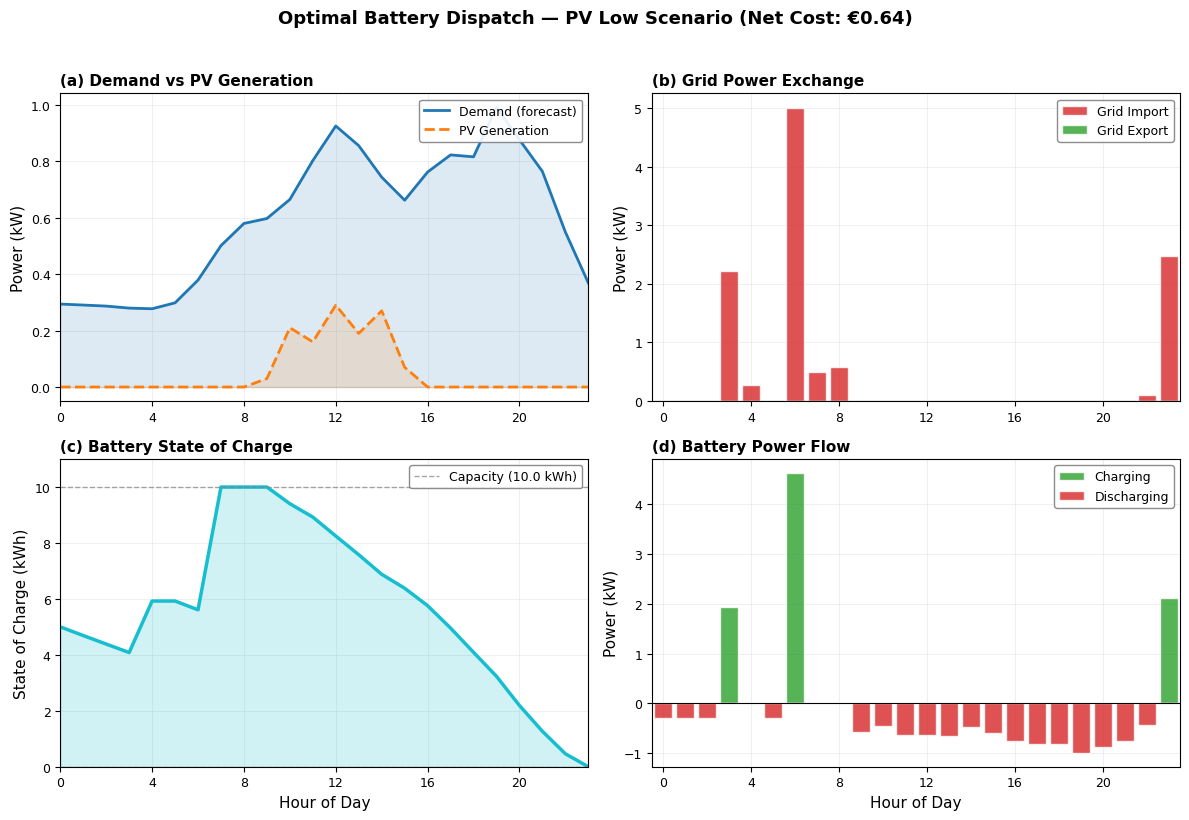

✓ Figure saved: 11_optimization_PV_low.png


In [ ]:

# STEP 6: Visualization - PV_low scenario dispatch (Academic Style)


if result_low and result_high:
    hours = np.arange(T)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    # Top left: Demand and PV
    ax = axes[0, 0]
    ax.plot(hours, demand, label="Demand (forecast)", color=COLORS["demand"], linewidth=2)
    ax.plot(hours, pv_low, label="PV Generation", color=COLORS["pv"], linestyle="--", linewidth=2)
    ax.fill_between(hours, 0, demand, alpha=0.15, color=COLORS["demand"])
    ax.fill_between(hours, 0, pv_low, alpha=0.15, color=COLORS["pv"])
    ax.set_ylabel("Power (kW)", fontweight="medium")
    ax.set_title("(a) Demand vs PV Generation", fontsize=11, fontweight="bold", loc="left")
    ax.legend(loc="upper right", framealpha=0.9)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 4))
    
    # Top right: Grid flows
    ax = axes[0, 1]
    width = 0.8
    ax.bar(hours, result_low["grid_import"], width, color=COLORS["grid_import"], alpha=0.8, label="Grid Import", edgecolor="white")
    ax.bar(hours, -result_low["grid_export"], width, color=COLORS["grid_export"], alpha=0.8, label="Grid Export", edgecolor="white")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_ylabel("Power (kW)", fontweight="medium")
    ax.set_title("(b) Grid Power Exchange", fontsize=11, fontweight="bold", loc="left")
    ax.legend(loc="upper right", framealpha=0.9)
    ax.set_xlim(-0.5, 23.5)
    ax.set_xticks(range(0, 24, 4))
    
    # Bottom left: SOC
    ax = axes[1, 0]
    ax.plot(hours, result_low["soc"][:-1], color=COLORS["soc"], linewidth=2.5)
    ax.axhline(BATT_CAP, color="gray", linestyle="--", alpha=0.7, linewidth=1, label=f"Capacity ({BATT_CAP} kWh)")
    ax.axhline(0, color="gray", linestyle="--", alpha=0.7, linewidth=1)
    ax.fill_between(hours, 0, result_low["soc"][:-1], alpha=0.2, color=COLORS["soc"])
    ax.set_xlabel("Hour of Day", fontweight="medium")
    ax.set_ylabel("State of Charge (kWh)", fontweight="medium")
    ax.set_title("(c) Battery State of Charge", fontsize=11, fontweight="bold", loc="left")
    ax.legend(loc="upper right", framealpha=0.9)
    ax.set_ylim(0, BATT_CAP * 1.1)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 4))
    
    # Bottom right: Battery power
    ax = axes[1, 1]
    ax.bar(hours, result_low["charge"], width, color=COLORS["grid_export"], alpha=0.8, label="Charging", edgecolor="white")
    ax.bar(hours, -result_low["discharge"], width, color=COLORS["grid_import"], alpha=0.8, label="Discharging", edgecolor="white")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xlabel("Hour of Day", fontweight="medium")
    ax.set_ylabel("Power (kW)", fontweight="medium")
    ax.set_title("(d) Battery Power Flow", fontsize=11, fontweight="bold", loc="left")
    ax.legend(loc="upper right", framealpha=0.9)
    ax.set_xlim(-0.5, 23.5)
    ax.set_xticks(range(0, 24, 4))
    
    fig.suptitle(f"Optimal Battery Dispatch — PV Low Scenario (Net Cost: €{result_low['cost']:.2f})", 
                 fontsize=13, fontweight="bold", y=1.02)
    
    save_figure(fig, "11_optimization_PV_low.png")

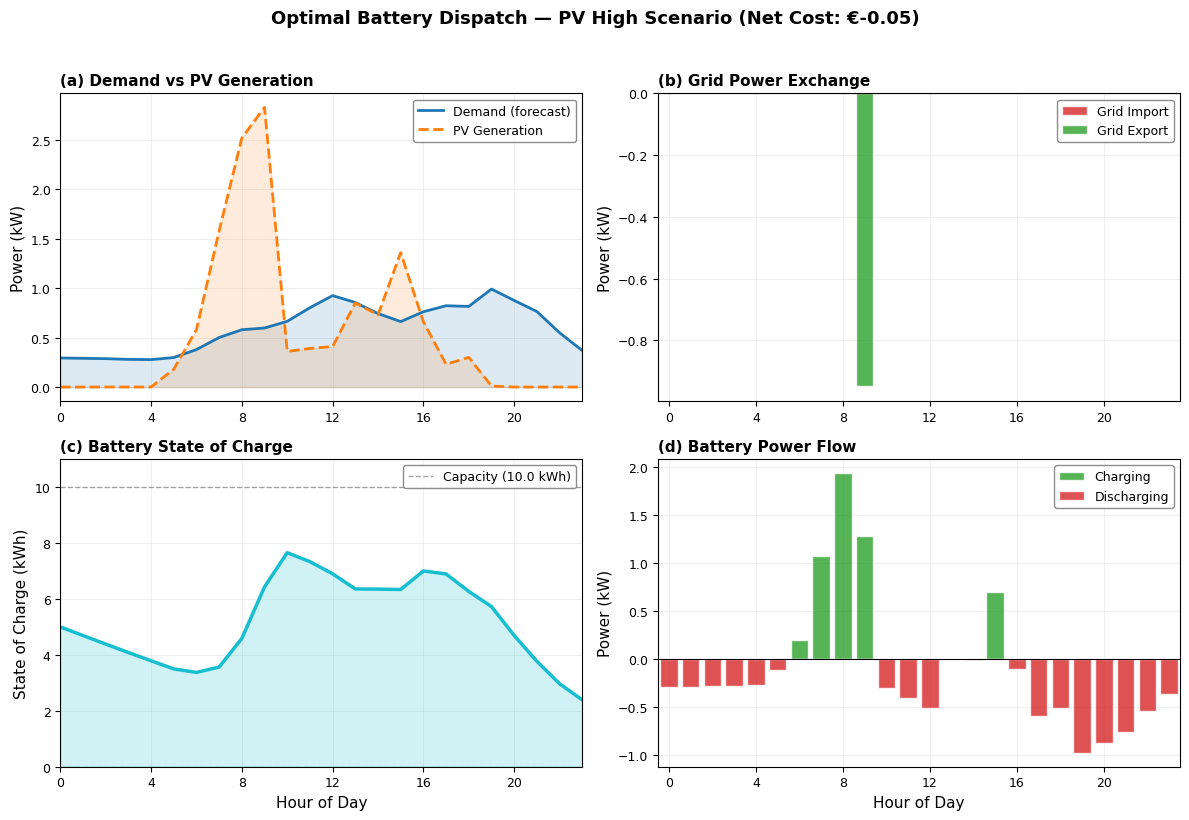

✓ Figure saved: 11_optimization_PV_high.png


In [ ]:

# STEP 7: Visualization - PV_high scenario dispatch (Academic Style)


if result_low and result_high:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.patch.set_facecolor('white')
    width = 0.8
    
    # Top left: Demand and PV
    ax = axes[0, 0]
    ax.plot(hours, demand, label="Demand (forecast)", color=COLORS["demand"], linewidth=2)
    ax.plot(hours, pv_high, label="PV Generation", color=COLORS["pv"], linestyle="--", linewidth=2)
    ax.fill_between(hours, 0, demand, alpha=0.15, color=COLORS["demand"])
    ax.fill_between(hours, 0, pv_high, alpha=0.15, color=COLORS["pv"])
    ax.set_ylabel("Power (kW)", fontweight="medium")
    ax.set_title("(a) Demand vs PV Generation", fontsize=11, fontweight="bold", loc="left")
    ax.legend(loc="upper right", framealpha=0.9)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 4))
    
    # Top right: Grid flows
    ax = axes[0, 1]
    ax.bar(hours, result_high["grid_import"], width, color=COLORS["grid_import"], alpha=0.8, label="Grid Import", edgecolor="white")
    ax.bar(hours, -result_high["grid_export"], width, color=COLORS["grid_export"], alpha=0.8, label="Grid Export", edgecolor="white")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_ylabel("Power (kW)", fontweight="medium")
    ax.set_title("(b) Grid Power Exchange", fontsize=11, fontweight="bold", loc="left")
    ax.legend(loc="upper right", framealpha=0.9)
    ax.set_xlim(-0.5, 23.5)
    ax.set_xticks(range(0, 24, 4))
    
    # Bottom left: SOC
    ax = axes[1, 0]
    ax.plot(hours, result_high["soc"][:-1], color=COLORS["soc"], linewidth=2.5)
    ax.axhline(BATT_CAP, color="gray", linestyle="--", alpha=0.7, linewidth=1, label=f"Capacity ({BATT_CAP} kWh)")
    ax.axhline(0, color="gray", linestyle="--", alpha=0.7, linewidth=1)
    ax.fill_between(hours, 0, result_high["soc"][:-1], alpha=0.2, color=COLORS["soc"])
    ax.set_xlabel("Hour of Day", fontweight="medium")
    ax.set_ylabel("State of Charge (kWh)", fontweight="medium")
    ax.set_title("(c) Battery State of Charge", fontsize=11, fontweight="bold", loc="left")
    ax.legend(loc="upper right", framealpha=0.9)
    ax.set_ylim(0, BATT_CAP * 1.1)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 4))
    
    # Bottom right: Battery power
    ax = axes[1, 1]
    ax.bar(hours, result_high["charge"], width, color=COLORS["grid_export"], alpha=0.8, label="Charging", edgecolor="white")
    ax.bar(hours, -result_high["discharge"], width, color=COLORS["grid_import"], alpha=0.8, label="Discharging", edgecolor="white")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_xlabel("Hour of Day", fontweight="medium")
    ax.set_ylabel("Power (kW)", fontweight="medium")
    ax.set_title("(d) Battery Power Flow", fontsize=11, fontweight="bold", loc="left")
    ax.legend(loc="upper right", framealpha=0.9)
    ax.set_xlim(-0.5, 23.5)
    ax.set_xticks(range(0, 24, 4))
    
    fig.suptitle(f"Optimal Battery Dispatch — PV High Scenario (Net Cost: €{result_high['cost']:.2f})", 
                 fontsize=13, fontweight="bold", y=1.02)
    
    save_figure(fig, "11_optimization_PV_high.png")

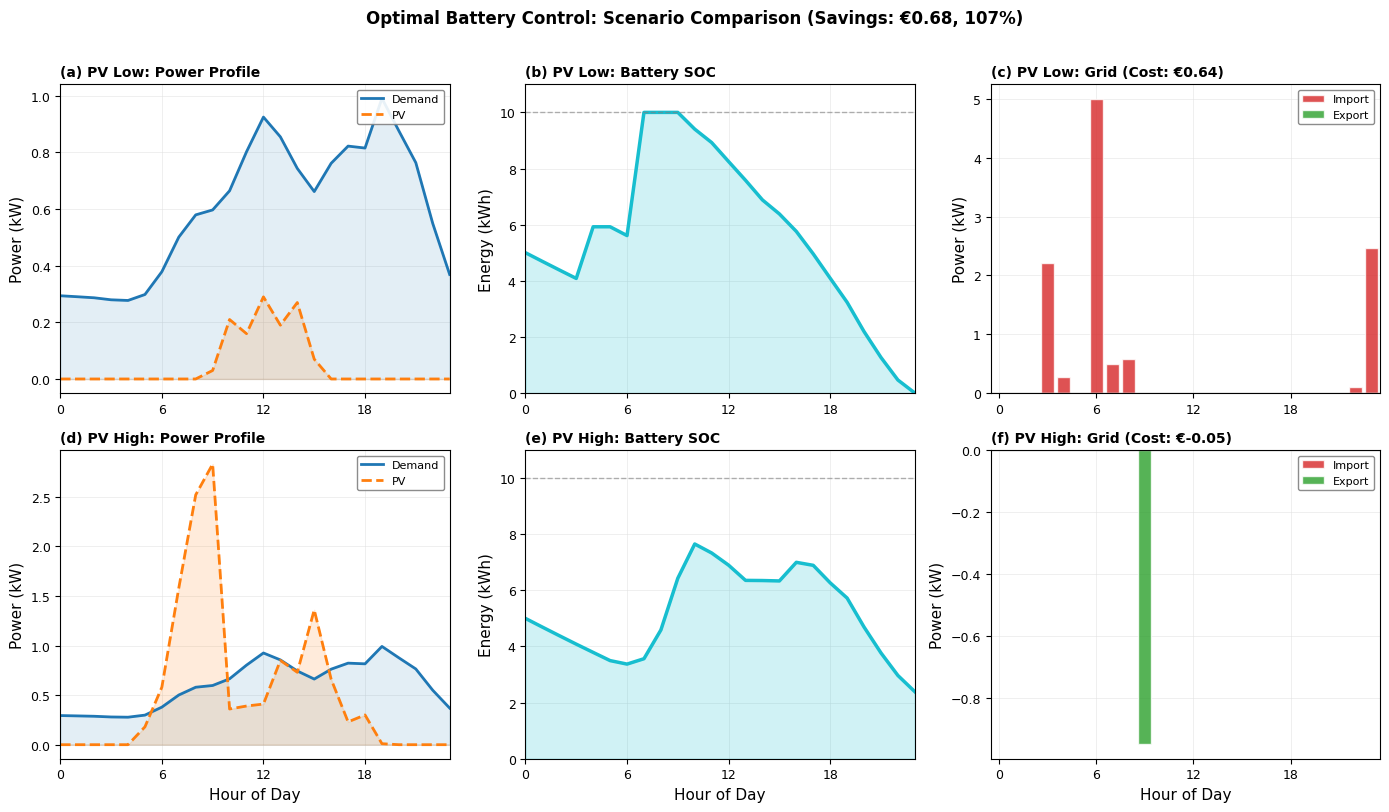

✓ Figure saved: 11_optimization_combined.png


In [ ]:

# STEP 8: Combined comparison plot (PV_low vs PV_high)


if result_low and result_high:
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    fig.patch.set_facecolor('white')
    hours = np.arange(T)
    width = 0.8
    

    # Row 1: PV_low scenario

    ax = axes[0, 0]
    ax.plot(hours, demand, color=COLORS["demand"], linewidth=2, label='Demand')
    ax.plot(hours, pv_low, color=COLORS["pv"], linestyle='--', linewidth=2, label='PV')
    ax.fill_between(hours, 0, demand, alpha=0.12, color=COLORS["demand"])
    ax.fill_between(hours, 0, pv_low, alpha=0.15, color=COLORS["pv"])
    ax.set_ylabel('Power (kW)', fontweight="medium")
    ax.set_title('(a) PV Low: Power Profile', fontsize=10, fontweight="bold", loc="left")
    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 6))
    
    ax = axes[0, 1]
    ax.plot(hours, result_low["soc"][:-1], color=COLORS["soc"], linewidth=2.5)
    ax.axhline(BATT_CAP, color='gray', linestyle='--', alpha=0.6, linewidth=1)
    ax.fill_between(hours, 0, result_low["soc"][:-1], alpha=0.2, color=COLORS["soc"])
    ax.set_ylabel('Energy (kWh)', fontweight="medium")
    ax.set_title('(b) PV Low: Battery SOC', fontsize=10, fontweight="bold", loc="left")
    ax.set_ylim(0, BATT_CAP * 1.1)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 6))
    
    ax = axes[0, 2]
    ax.bar(hours, result_low["grid_import"], width, color=COLORS["grid_import"], alpha=0.8, label='Import', edgecolor="white")
    ax.bar(hours, -result_low["grid_export"], width, color=COLORS["grid_export"], alpha=0.8, label='Export', edgecolor="white")
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylabel('Power (kW)', fontweight="medium")
    ax.set_title(f'(c) PV Low: Grid (Cost: €{result_low["cost"]:.2f})', fontsize=10, fontweight="bold", loc="left")
    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax.set_xlim(-0.5, 23.5)
    ax.set_xticks(range(0, 24, 6))
    
    #PV_high scenario

    ax = axes[1, 0]
    ax.plot(hours, demand, color=COLORS["demand"], linewidth=2, label='Demand')
    ax.plot(hours, pv_high, color=COLORS["pv"], linestyle='--', linewidth=2, label='PV')
    ax.fill_between(hours, 0, demand, alpha=0.12, color=COLORS["demand"])
    ax.fill_between(hours, 0, pv_high, alpha=0.15, color=COLORS["pv"])
    ax.set_xlabel('Hour of Day', fontweight="medium")
    ax.set_ylabel('Power (kW)', fontweight="medium")
    ax.set_title('(d) PV High: Power Profile', fontsize=10, fontweight="bold", loc="left")
    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 6))
    
    ax = axes[1, 1]
    ax.plot(hours, result_high["soc"][:-1], color=COLORS["soc"], linewidth=2.5)
    ax.axhline(BATT_CAP, color='gray', linestyle='--', alpha=0.6, linewidth=1)
    ax.fill_between(hours, 0, result_high["soc"][:-1], alpha=0.2, color=COLORS["soc"])
    ax.set_xlabel('Hour of Day', fontweight="medium")
    ax.set_ylabel('Energy (kWh)', fontweight="medium")
    ax.set_title('(e) PV High: Battery SOC', fontsize=10, fontweight="bold", loc="left")
    ax.set_ylim(0, BATT_CAP * 1.1)
    ax.set_xlim(0, 23)
    ax.set_xticks(range(0, 24, 6))
    
    ax = axes[1, 2]
    ax.bar(hours, result_high["grid_import"], width, color=COLORS["grid_import"], alpha=0.8, label='Import', edgecolor="white")
    ax.bar(hours, -result_high["grid_export"], width, color=COLORS["grid_export"], alpha=0.8, label='Export', edgecolor="white")
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xlabel('Hour of Day', fontweight="medium")
    ax.set_ylabel('Power (kW)', fontweight="medium")
    ax.set_title(f'(f) PV High: Grid (Cost: €{result_high["cost"]:.2f})', fontsize=10, fontweight="bold", loc="left")
    ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax.set_xlim(-0.5, 23.5)
    ax.set_xticks(range(0, 24, 6))
    
    # Calculate savings for title
    savings = result_low['cost'] - result_high['cost']
    savings_pct = (savings / result_low['cost'] * 100) if result_low['cost'] > 0 else 0
    
    fig.suptitle(f'Optimal Battery Control: Scenario Comparison (Savings: €{savings:.2f}, {savings_pct:.0f}%)', 
                 fontsize=12, fontweight="bold", y=1.01)
    
    save_figure(fig, "11_optimization_combined.png")

In [ ]:

# STEP 9: Create detailed dispatch schedule table


if result_low and result_high:
    # Create hourly dispatch table for both scenarios
    dispatch_df = pd.DataFrame({
        "Hour": hours,
        "Demand_kW": np.round(demand, 3),
        "Price_EUR": np.round(price_buy, 4),
        # PV_low scenario
        "PV_low_kW": np.round(pv_low, 3),
        "Import_low_kW": np.round(result_low["grid_import"], 3),
        "Export_low_kW": np.round(result_low["grid_export"], 3),
        "Charge_low_kW": np.round(result_low["charge"], 3),
        "Discharge_low_kW": np.round(result_low["discharge"], 3),
        "SOC_low_kWh": np.round(result_low["soc"][:-1], 3),
        # PV_high scenario
        "PV_high_kW": np.round(pv_high, 3),
        "Import_high_kW": np.round(result_high["grid_import"], 3),
        "Export_high_kW": np.round(result_high["grid_export"], 3),
        "Charge_high_kW": np.round(result_high["charge"], 3),
        "Discharge_high_kW": np.round(result_high["discharge"], 3),
        "SOC_high_kWh": np.round(result_high["soc"][:-1], 3),
    })
    
    display_table(dispatch_df, "11_optimal_dispatch_schedule.csv")
    print(f"Dispatch schedule saved with {len(dispatch_df)} hourly entries")


,Hour,Demand_kW,Price_EUR,PV_low_kW,Import_low_kW,Export_low_kW,Charge_low_kW,Discharge_low_kW,SOC_low_kWh,PV_high_kW,Import_high_kW,Export_high_kW,Charge_high_kW,Discharge_high_kW,SOC_high_kWh
0,0,0.294,0.0610,0.00,0.000,0.0,0.000,0.294,5.000,0.00,0.0,0.000,0.000,0.294,5.000
1,1,0.290,0.0701,0.00,0.000,0.0,0.000,0.290,4.691,0.00,0.0,0.000,0.000,0.290,4.691
2,2,0.287,0.0700,0.00,0.000,0.0,0.000,0.287,4.385,0.00,0.0,0.000,0.000,0.287,4.385
3,3,0.280,0.0550,0.00,2.217,0.0,1.938,0.000,4.083,0.00,0.0,0.000,0.000,0.280,4.083
4,4,0.277,0.0576,0.00,0.277,0.0,0.000,0.000,5.924,0.00,0.0,0.000,0.000,0.277,3.789
5,5,0.298,0.0701,0.00,0.000,0.0,0.000,0.298,5.924,0.18,0.0,0.000,0.000,0.118,3.497
6,6,0.379,0.0497,0.00,5.000,0.0,4.621,0.000,5.610,0.58,0.0,0.000,0.201,0.000,3.372
7,7,0.501,0.0681,0.00,0.501,0.0,0.000,0.000,10.000,1.58,0.0,0.000,1.079,0.000,3.563
8,8,0.580,0.0749,0.00,0.580,0.0,0.000,0.000,10.000,2.52,0.0,0.000,1.940,0.000,4.588
9,9,0.597,0.0968,0.03,0.000,0.0,0.000,0.567,10.000,2.83,0.0,0.948,1.285,0.000,6.432


Dispatch schedule saved with 24 hourly entries
